# EMG Hand Gesture Classification

**Load Packages**

In [1]:
import features
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

**Reading Dataset**

In [2]:
df = pd.read_csv("data.csv")
df

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4237902,50962,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36
4237903,50963,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36
4237904,50964,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36
4237905,50965,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36


**Seperate Dataset into Classes**

In [3]:
class_dict = {}
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
for idx in range(1, 8):
    class_idx = df.loc[:, 'class'].values == idx
    new_df = df[class_idx].reset_index(drop=True)
    class_dict[class_names[idx-1]] = new_df

**Extract Features**

In [4]:
window_length = 2000

In [5]:
def segment_signal(signal, window_length):
    num_windows = len(signal) // window_length
    truncated_signal = signal[:num_windows * window_length]  # Truncate to fit whole windows
    windows = np.array([truncated_signal[i * window_length:(i + 1) * window_length] 
                        for i in range(num_windows)])
    return windows

def segment_channel(df_channels, channel_idx, window_length):
    # Extract the channel data 
    raw_channel_vector = df_channels[f'channel{channel_idx}'].values
    return segment_signal(raw_channel_vector, window_length)

def process_classes(class_dict, window_length, features):
    class_data = None
    labels = []
    for class_idx in range(1, 8):  # Assuming 7 classes
        df_class = class_dict[f'Class {class_idx}']
        class_channel_data = None
        for channel_idx in range(1, 9):  # Assuming 8 channels
            segmented_channel = segment_channel(df_class, channel_idx, window_length)
            channel_features = []
            # Extract features for each segment
            for vector in segmented_channel:
                data_features, feature_names = features.extract_features(vector)
                channel_features.append(data_features)
                # Append labels only once per class (on first channel)
                if channel_idx == 1:
                    labels.append(class_idx)
            # Stack features across segments for the current channel
            channel_features = np.array(channel_features)
            # Concatenate features across all channels
            if channel_idx == 1:
                class_channel_data = channel_features
            else:
                class_channel_data = np.hstack([class_channel_data, channel_features])
        # Stack features across all classes
        if class_idx == 1:
            class_data = class_channel_data
        else:
            class_data = np.vstack([class_data, class_channel_data])
    labels = np.array(labels)
    return class_data, labels, feature_names

In [6]:
class_data, labels, feature_names = process_classes(class_dict, window_length, features)
print(f'Class Data Shape: {class_data.shape}')
print(f'Class Labels Shape: {labels.shape}')

Class Data Shape: (752, 128)
Class Labels Shape: (752,)


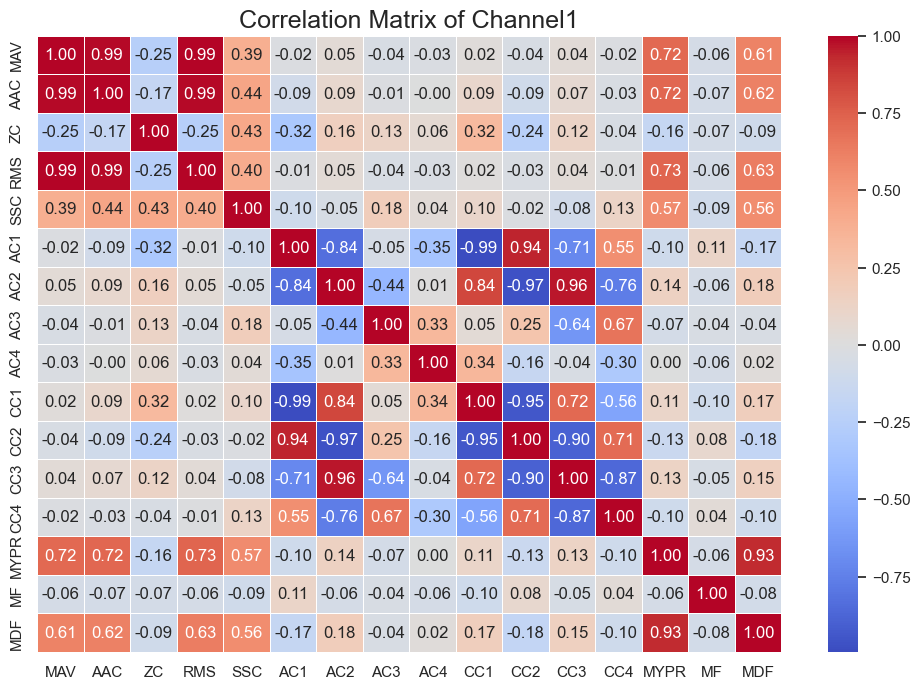

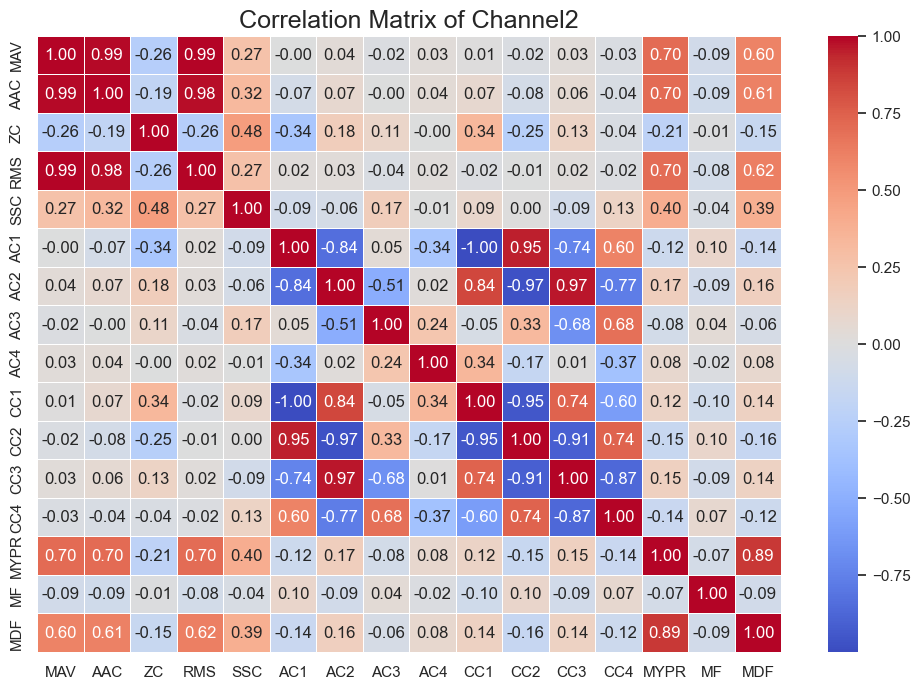

In [7]:
df_class_data = pd.DataFrame(class_data[:, :16], columns=feature_names)  # Convert to DataFrame for labeling
correlation_matrix = df_class_data.corr()

plt.figure(figsize=(12, 8))
sns.set(style='white')  # Set the background style to white
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Channel1', fontsize=18)
plt.show()

df_class_data = pd.DataFrame(class_data[:, 16:32], columns=feature_names)  # Convert to DataFrame for labeling
correlation_matrix = df_class_data.corr()

plt.figure(figsize=(12, 8))
sns.set(style='white')  # Set the background style to white
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Channel2', fontsize=18)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(class_data, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8675


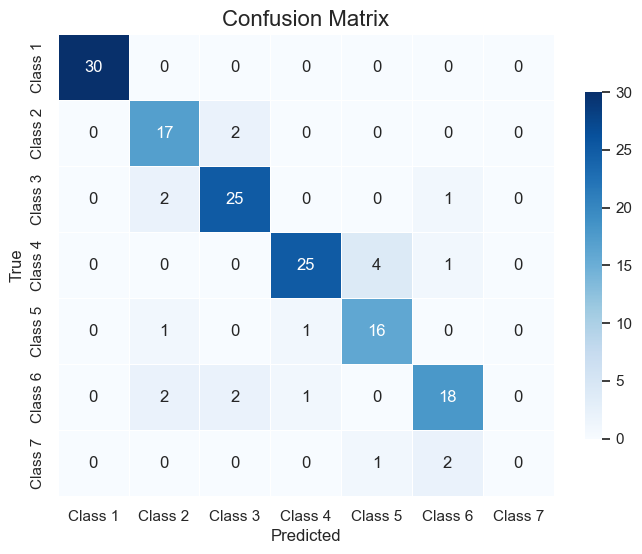

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
class_labels = [f'Class {i}' for i in range(1, 8)]
plt.figure(figsize=(8, 6))
sns.set(style='white')  # Use white background for clean look
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5,
                      xticklabels=class_labels, yticklabels=class_labels,
                      cbar_kws={'shrink': 0.75})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

In [11]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.8278


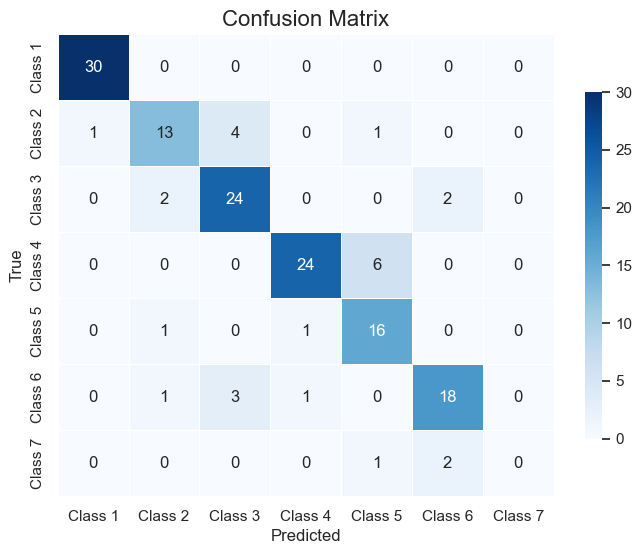

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
class_labels = [f'Class {i}' for i in range(1, 8)]
plt.figure(figsize=(8, 6))
sns.set(style='white')  # Use white background for clean look
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5,
                      xticklabels=class_labels, yticklabels=class_labels,
                      cbar_kws={'shrink': 0.75})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()